In [3]:
!pip install kneed


In [4]:
pip install kneed


Note: you may need to restart the kernel to use updated packages.


In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from kneed import KneeLocator

plt.style.use('ggplot')

# Carga de datos
def load_data(excel_file):
    """Carga los datos y asigna los nombres de clientes."""
    xls = pd.ExcelFile(excel_file)
    clients = xls.sheet_names
    
    dfs = []
    
    for client in clients:
        # Load the data from each sheet
        df = pd.read_excel(xls, sheet_name=client)
        # Add a column for the client name
        df['Cliente'] = client
        # Append the dataframe to the list
        dfs.append(df)
    
    full_df = pd.concat(dfs, ignore_index=True)
    
    return full_df

def preprocess_data(df):
    """Preprocesa los datos"""
    # Convert the 'Fecha' column to datetime format
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values(by=['Cliente', 'Fecha'])
    
    # Extract date features
    df['Hora'] = df['Fecha'].dt.hour
    df['Dia_Semana'] = df['Fecha'].dt.dayofweek
    df['Mes'] = df['Fecha'].dt.month
    df['Dia_Año'] = df['Fecha'].dt.dayofyear
    
    # Daily aggregation
    daily_df = df.groupby(['Cliente', pd.Grouper(key='Fecha', freq='D')]).agg({
        'Volumen': 'sum',
        'Temperatura': 'mean',
        'Presion': 'mean',
    })
    
    return daily_df

def scale_features(df):
    """Escala las características numéricas"""
    scaler = StandardScaler()
    numeric_cols = ["Volumen", "Temperatura", "Presion"]
    scaled_data = scaler.fit_transform(df[numeric_cols])
    
    # New scaled columns
    df[[f"{col}_scaled" for col in numeric_cols]] = scaled_data
    return df, scaler

def exploratory_plots(df):
    """Genera gráficos exploratorios para analizar los datos de clientes"""
    # Mostrar la distribución de los 5 primeros clientes
    unique_clients = df.index.get_level_values("Cliente").unique()[:5]
    for client in unique_clients:
        client_data = df.xs(client, level="Cliente")
        client_data = client_data.sort_index()  # Asegura orden por fecha

        # Crear figura con dos subgráficos (2 columnas)
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f"Análisis del Cliente {client}", fontsize=16)

        # Histograma de volumen
        sns.histplot(client_data["Volumen"], kde=True, ax=axes[0])
        axes[0].set_title("Distribución del Volumen")
        axes[0].set_xlabel("Volumen")
        axes[0].set_ylabel("Frecuencia")

        # Serie temporal
        axes[1].plot(client_data.index, client_data["Volumen"], marker='o')
        axes[1].set_title("Consumo Histórico Diario")
        axes[1].set_xlabel("Fecha")
        axes[1].set_ylabel("Volumen")
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def data_pipeline(file_path):
    """Pipeline completo de procesamiento de datos"""
    # Carga
    raw_df = load_data(file_path)
    
    # Procesamiento
    processed_df = preprocess_data(raw_df)
    
    # Escalado
    final_df, scaler = scale_features(processed_df)
    
    return final_df, scaler

# Funciones de clustering

def elbow_method(data, max_k=15, plot=True):
    """
    Devuelve el k óptimo calculado automáticamente
    """
    sse = []
    k_values = range(1, max_k+1)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    
    # Detección automática del codo
    kneedle = KneeLocator(k_values, sse, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow if kneedle.elbow else 3  # Fallback a 3 si no detecta
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(k_values, sse, 'bo-')
        plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
        plt.xlabel('Número de Clusters (k)')
        plt.ylabel('SSE')
        plt.title(f'Método del Codo (K óptimo = {optimal_k})')
        plt.grid(True)
        plt.show()
    
    return optimal_k, sse

def find_optimal_eps(data, min_samples=5, plot=True):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    
    distances = np.sort(distances[:, -1], axis=0)
    
    # Calcular punto de máxima curvatura
    kneedle = KneeLocator(np.arange(len(distances)), distances, curve='convex', direction='increasing')
    optimal_eps = distances[kneedle.elbow] if kneedle.elbow else np.quantile(distances, 0.95)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(distances)
        plt.hlines(optimal_eps, 0, len(distances), colors='r', linestyles='dashed')
        plt.xlabel('Puntos')
        plt.ylabel(f'Distancia a {min_samples} vecinos')
        plt.title(f'Sugerencia de epsilon óptimo: {optimal_eps:.2f}')
        plt.grid(True)
        plt.show()
    
    return optimal_eps, distances

def clustering_pipeline(data, use_auto_k=True, focus_features=None):
    """
    Pipeline de clustering:
    - Selección automática de parámetros
    - Métricas detalladas
    - Manejo de múltiples modelos
    
    Args:
        data: DataFrame con las columnas _scaled para clustering
        use_auto_k: Si usa el método del codo para determinar k óptimo
        focus_features: Lista de características para enfocar el clustering (ej: ["Volumen_scaled"])
    """
    # Si se especifican características, usamos solo esas
    if focus_features:
        X = data[focus_features].values
    else:
        X = data.filter(like='_scaled').values
    
    results = []
    
    # Configuración ampliada de modelos
    models_config = {
        'KMeans': {
            'model': KMeans(random_state=42, n_init=10),
            'params': {'n_clusters': [2, 3, 4, 5, 6, 7, 8]}
        },
        'DBSCAN': {
            'model': DBSCAN(),
            'params': {
                'eps': [0.3, 0.5, 0.7],
                'min_samples': [3, 5, 7]
            }
        },
        'Agglomerative': {
            'model': AgglomerativeClustering(),
            'params': {'n_clusters': [2, 3, 4, 5, 6]}
        }
    }
    
    # Optimización automática de K para KMeans
    if use_auto_k:
        optimal_k, _ = elbow_method(X, plot=True)
        models_config['KMeans']['params']['n_clusters'] = [optimal_k-1, optimal_k, optimal_k+1]
    
    # Búsqueda de parámetros para DBSCAN
    optimal_eps, _ = find_optimal_eps(X, plot=True)
    models_config['DBSCAN']['params']['eps'] = np.linspace(
        optimal_eps*0.5, optimal_eps*1.5, 5
    ).tolist()
    
    # Evaluación de modelos
    for model_name, config in models_config.items():
        print(f"\n=== Evaluando {model_name} ===")
        
        for params in ParameterGrid(config['params']):
            try:
                model = config['model'].set_params(**params)
                labels = model.fit_predict(X)
                
                # Ignorar resultados con muchos clusters o pocos
                unique_labels = len(np.unique(labels[labels != -1])) if -1 in labels else len(np.unique(labels))
                if unique_labels < 2 or unique_labels > 15:
                    continue
                
                # Calcular métricas solo si hay más de un cluster y no todos son ruido
                if unique_labels >= 2 and np.sum(labels != -1) > 0:
                    # Silhouette solo para puntos no considerados ruido en DBSCAN
                    if -1 in labels:
                        silhouette = silhouette_score(X[labels != -1], labels[labels != -1]) if np.sum(labels != -1) > 1 else 0
                        calinski = calinski_harabasz_score(X[labels != -1], labels[labels != -1]) if np.sum(labels != -1) > 1 else 0
                    else:
                        silhouette = silhouette_score(X, labels)
                        calinski = calinski_harabasz_score(X, labels)
                    
                    # Calcular métricas
                    metrics = {
                        'model': model_name,
                        'params': params.copy(),
                        'n_clusters': unique_labels,
                        'silhouette': silhouette,
                        'calinski': calinski,
                        'noise_ratio': np.sum(labels == -1)/len(labels) if -1 in labels else 0
                    }
                    results.append(metrics)
                    
                    print(f"Params: {params} | Clusters: {unique_labels} | Silhouette: {metrics['silhouette']:.3f}")
                
            except Exception as e:
                print(f"Error con {params}: {str(e)}")
    
    return pd.DataFrame(results)

def get_model_from_row(row):
    """Helper para recrear modelos desde el DataFrame"""
    if row['model'] == 'KMeans':
        return KMeans(**row['params'], random_state=42, n_init=10)
    elif row['model'] == 'DBSCAN':
        return DBSCAN(**row['params'])
    elif row['model'] == 'Agglomerative':
        return AgglomerativeClustering(**row['params'])

def plot_all_clusters(data, results_df, feature_cols=None, n_cols=3):
    """
    Visualización unificada de todos los modelos
    
    Args:
        data: DataFrame con datos
        results_df: DataFrame con resultados de clustering
        feature_cols: Lista de características para visualizar (si None, usa todas las _scaled)
        n_cols: Número de columnas en la visualización
    """
    if feature_cols:
        X = data[feature_cols].values
    else:
        X = data.filter(like='_scaled').values
    
    # Si tenemos más de 2 dimensiones, reducir con PCA
    if X.shape[1] > 2:
        pca = PCA(n_components=2).fit(X)
        X_pca = pca.transform(X)
        dim1, dim2 = 0, 1
        xlabel = f'PC1 ({pca.explained_variance_ratio_[0]:.1%})'
        ylabel = f'PC2 ({pca.explained_variance_ratio_[1]:.1%})'
    else:
        X_pca = X
        dim1, dim2 = 0, 0 if X.shape[1] == 1 else 1
        xlabel = feature_cols[dim1] if feature_cols else 'Dim 1'
        ylabel = feature_cols[dim2] if feature_cols and len(feature_cols) > 1 else 'Dim 2'
    
    n_models = len(results_df)
    n_rows = int(np.ceil(n_models / n_cols))
    
    plt.figure(figsize=(18, 5*n_rows))
    
    for idx, (_, row) in enumerate(results_df.iterrows(), 1):
        model = get_model_from_row(row)
        labels = model.fit_predict(X)
        
        plt.subplot(n_rows, n_cols, idx)
        
        # Si solo tenemos 1 dimensión, agregamos un eje aleatorio para visualización
        if X.shape[1] == 1:
            x_vals = X_pca[:, dim1]
            y_vals = np.random.normal(0, 0.1, size=len(x_vals))  # Pequeño jitter
        else:
            x_vals = X_pca[:, dim1]
            y_vals = X_pca[:, dim2]
            
        scatter = plt.scatter(x_vals, y_vals, c=labels, cmap='tab20', alpha=0.6)
        
        # Añadir leyenda
        if -1 in labels:
            from matplotlib.lines import Line2D
            noise_idx = np.where(labels == -1)[0]
            if len(noise_idx) > 0:
                legend_elements = [Line2D([0], [0], marker='o', color='w', 
                                         markerfacecolor=scatter.cmap(-1), markersize=10, label='Ruido')]
                plt.legend(handles=legend_elements, loc='upper right')
        
        plt.title(f"{row['model']}\n{row['params']}\nSilhouette: {row['silhouette']:.2f}")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

def analyze_clusters(data, model, labels, focus_features=None):
    """
    Analiza las características de cada cluster
    
    Args:
        data: DataFrame original
        model: Modelo de clustering
        labels: Etiquetas asignadas
        focus_features: Características a analizar (si None, analiza todas)
    """
    # Crear una copia de los datos para análisis
    analysis_df = data.copy()
    
    # Resetear índice para poder asignar etiquetas de cluster
    if isinstance(analysis_df.index, pd.MultiIndex):
        analysis_df = analysis_df.reset_index()
    
    # Asignar etiquetas de cluster
    analysis_df['Cluster'] = labels
    
    # Seleccionar características para análisis
    if focus_features:
        features_to_analyze = focus_features
    else:
        # Usar las columnas originales sin '_scaled'
        features_to_analyze = [col for col in data.columns if not col.endswith('_scaled')]
    
    # Análisis por cluster
    cluster_summary = analysis_df.groupby('Cluster')[features_to_analyze].agg(['mean', 'median', 'std', 'count'])
    
    # Formatear para mejor visualización
    cluster_summary = cluster_summary.round(2)
    
    print("\n=== Análisis de Clusters ===")
    print(f"Número de clusters: {len(np.unique(labels[labels != -1]))}")
    
    if -1 in labels:
        print(f"Puntos clasificados como ruido: {np.sum(labels == -1)} ({np.sum(labels == -1)/len(labels):.1%})")
    
    print("\nEstadísticas por cluster:")
    display(cluster_summary)
    
    # Gráficos de distribución por variable y cluster
    for feature in features_to_analyze:
        plt.figure(figsize=(14, 6))
        
        for cluster in sorted(analysis_df['Cluster'].unique()):
            if cluster == -1:  # Opcional: distinguir ruido
                sns.kdeplot(analysis_df[analysis_df['Cluster'] == cluster][feature], 
                          label=f'Ruido (Cluster {cluster})', linestyle='--')
            else:
                sns.kdeplot(analysis_df[analysis_df['Cluster'] == cluster][feature], 
                          label=f'Cluster {cluster}')
        
        plt.title(f'Distribución de {feature} por Cluster')
        plt.xlabel(feature)
        plt.ylabel('Densidad')
        plt.legend()
        plt.show()
    
    return cluster_summary

def prepare_client_features(df):
    """
    Prepara características agregadas por cliente para clustering
    """
    # Crear estadísticas por cliente
    client_features = df.groupby('Cliente').agg({
        'Volumen': ['mean', 'std', 'median', 'max', 'min'],
        'Temperatura': ['mean', 'std'],
        'Presion': ['mean', 'std']
    })
    
    # Aplanar columnas multi-índice
    client_features.columns = ['_'.join(col).strip() for col in client_features.columns.values]
    
    # Calcular coeficiente de variación para volumen (variabilidad normalizada)
    client_features['Volumen_cv'] = client_features['Volumen_std'] / client_features['Volumen_mean']
    
    # Escalar características
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(client_features)
    
    client_features_scaled = pd.DataFrame(
        scaled_features, 
        index=client_features.index,
        columns=[f"{col}_scaled" for col in client_features.columns]
    )
    
    # Combinar características originales y escaladas
    result_df = pd.concat([client_features, client_features_scaled], axis=1)
    
    return result_df

def run_clustering_analysis(file_path, focus_on_volume=True):
    """
    Ejecuta el análisis completo de clustering enfocado en volumen de gas
    
    Args:
        file_path: Ruta al archivo Excel con datos
        focus_on_volume: Si True, enfoca el clustering solo en características de volumen
    """
    print("=== ANÁLISIS DE CLUSTERING DE CLIENTES POR CONSUMO DE GAS ===\n")
    
    # 1. Cargar y preprocesar datos
    print("1. Cargando y procesando datos...")
    daily_df, _ = data_pipeline(file_path)
    
    # 2. Agregar características por cliente
    print("\n2. Preparando características por cliente...")
    client_features = prepare_client_features(daily_df.reset_index())
    print(f"Características calculadas para {len(client_features)} clientes")
    
    # Mostrar las primeras filas
    print("\nPrimeras 5 filas de características por cliente:")
    display(client_features.head())
    
    # 3. Seleccionar características para clustering
    if focus_on_volume:
        print("\n3. Enfocando análisis en características de volumen...")
        volume_features = [col for col in client_features.columns if 'Volumen' in col and '_scaled' in col]
        print(f"Características seleccionadas: {volume_features}")
    else:
        volume_features = client_features.filter(like='_scaled').columns.tolist()
    
    # 4. Ejecutar pipeline de clustering
    print("\n4. Ejecutando pipeline de clustering...")
    clustering_results = clustering_pipeline(
        client_features, 
        use_auto_k=True,
        focus_features=volume_features
    )
    
    # 5. Ordenar y filtrar mejores resultados
    print("\n5. Analizando mejores resultados...")
    no_noise_models = clustering_results[clustering_results['noise_ratio'] == 0]
    best_results = no_noise_models.sort_values('silhouette', ascending=False).head(6)
    
    print("\n=== Mejores Modelos de Clustering ===")
    display(best_results[['model', 'params', 'silhouette', 'n_clusters', 'noise_ratio']])
    
    # 6. Visualizar clusters
    print("\n6. Visualizando clusters...")
    plot_all_clusters(client_features, best_results, feature_cols=volume_features, n_cols=2)
    
    # 7. Analizar el mejor modelo en detalle
    print("\n7. Analizando el mejor modelo en detalle...")
    best_model_row = best_results.iloc[0]
    best_model = get_model_from_row(best_model_row)
    
    # Seleccionar las características para el modelo
    X = client_features[volume_features].values
    
    # Obtener etiquetas
    best_labels = best_model.fit_predict(X)
    
    # Analizar clusters
    non_scaled_volume_features = [col.replace('_scaled', '') for col in volume_features]
    cluster_stats = analyze_clusters(
        client_features, 
        best_model, 
        best_labels, 
        focus_features=non_scaled_volume_features
    )
    
    return {
        'client_features': client_features,
        'best_model': best_model,
        'best_labels': best_labels,
        'cluster_stats': cluster_stats,
        'clustering_results': clustering_results
    }

=== ANÁLISIS DE CLUSTERING DE CLIENTES POR CONSUMO DE GAS ===

1. Cargando y procesando datos...

2. Preparando características por cliente...
Características calculadas para 20 clientes

Primeras 5 filas de características por cliente:


,Volumen_mean,Volumen_std,Volumen_median,Volumen_max,Volumen_min,Temperatura_mean,Temperatura_std,Presion_mean,Presion_std,Volumen_cv,Volumen_mean_scaled,Volumen_std_scaled,Volumen_median_scaled,Volumen_max_scaled,Volumen_min_scaled,Temperatura_mean_scaled,Temperatura_std_scaled,Presion_mean_scaled,Presion_std_scaled,Volumen_cv_scaled
Cliente,,,,,,,,,,,,,,,,,,,,
CLIENTE1,478.860026,171.329178,539.876623,744.815774,0.000000,25.575156,2.631510,17.536047,0.357269,0.357786,-0.665168,-1.248342,-0.485277,-1.457463,-0.559506,0.207825,-0.296122,0.350816,0.746948,-0.658402
CLIENTE10,274.694717,868.119403,0.005025,4678.664176,0.000000,23.500909,2.474948,17.473135,0.116617,3.160306,-0.802307,0.648424,-0.809912,0.420433,-0.559506,-0.912998,-0.526571,0.335763,-1.315750,1.459860
CLIENTE11,3081.380391,733.498188,3265.882507,4349.616294,161.814959,26.325863,2.682944,3.545165,0.066437,0.238042,1.082959,0.281965,1.153921,0.263356,-0.191004,0.613471,-0.220414,-2.996773,-1.745859,-0.748909
CLIENTE12,795.689998,986.958291,9.590944,2871.474795,0.000000,26.651236,4.745830,17.834826,0.319406,1.240380,-0.452352,0.971921,-0.804148,-0.442262,-0.559506,0.789287,2.816009,0.422304,0.422407,0.008700
CLIENTE13,239.458506,807.438990,0.008312,4715.471431,0.000000,21.590516,2.665575,17.493262,0.099562,3.371937,-0.825975,0.483243,-0.809910,0.438004,-0.559506,-1.945282,-0.245980,0.340579,-1.461929,1.619819



3. Enfocando análisis en características de volumen...
Características seleccionadas: ['Volumen_mean_scaled', 'Volumen_std_scaled', 'Volumen_median_scaled', 'Volumen_max_scaled', 'Volumen_min_scaled', 'Volumen_cv_scaled']

4. Ejecutando pipeline de clustering...


C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

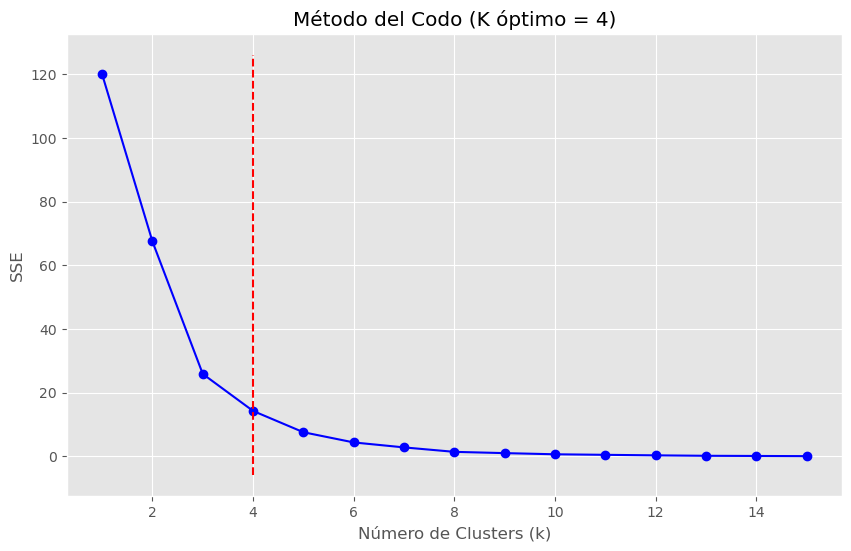

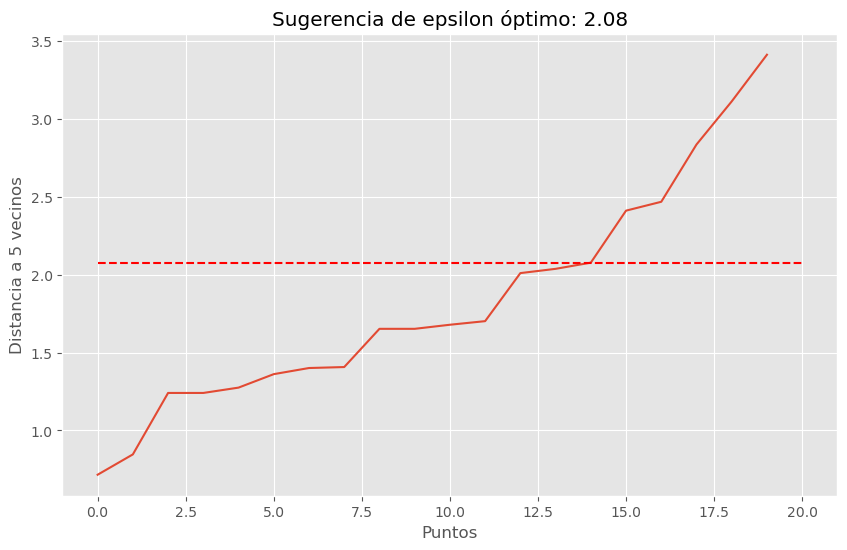


=== Evaluando KMeans ===


C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Params: {'n_clusters': 3} | Clusters: 3 | Silhouette: 0.588


C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Params: {'n_clusters': 4} | Clusters: 4 | Silhouette: 0.645


C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Params: {'n_clusters': 5} | Clusters: 5 | Silhouette: 0.651

=== Evaluando DBSCAN ===
Params: {'eps': 1.0389602716546091, 'min_samples': 3} | Clusters: 3 | Silhouette: 0.832
Params: {'eps': 1.5584404074819136, 'min_samples': 3} | Clusters: 3 | Silhouette: 0.731
Params: {'eps': 1.5584404074819136, 'min_samples': 5} | Clusters: 2 | Silhouette: 0.781
Params: {'eps': 2.077920543309218, 'min_samples': 3} | Clusters: 2 | Silhouette: 0.383
Params: {'eps': 2.077920543309218, 'min_samples': 7} | Clusters: 2 | Silhouette: 0.615

=== Evaluando Agglomerative ===
Params: {'n_clusters': 2} | Clusters: 2 | Silhouette: 0.425
Params: {'n_clusters': 3} | Clusters: 3 | Silhouette: 0.588
Params: {'n_clusters': 4} | Clusters: 4 | Silhouette: 0.645
Params: {'n_clusters': 5} | Clusters: 5 | Silhouette: 0.651
Params: {'n_clusters': 6} | Clusters: 6 | Silhouette: 0.713

5. Analizando mejores resultados...

=== Mejores Modelos de Clustering ===


,model,params,silhouette,n_clusters,noise_ratio
12,Agglomerative,{'n_clusters': 6},0.712510,6,0.0
2,KMeans,{'n_clusters': 5},0.650877,5,0.0
11,Agglomerative,{'n_clusters': 5},0.650877,5,0.0
1,KMeans,{'n_clusters': 4},0.644541,4,0.0
10,Agglomerative,{'n_clusters': 4},0.644541,4,0.0
0,KMeans,{'n_clusters': 3},0.588133,3,0.0



6. Visualizando clusters...


C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alfar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


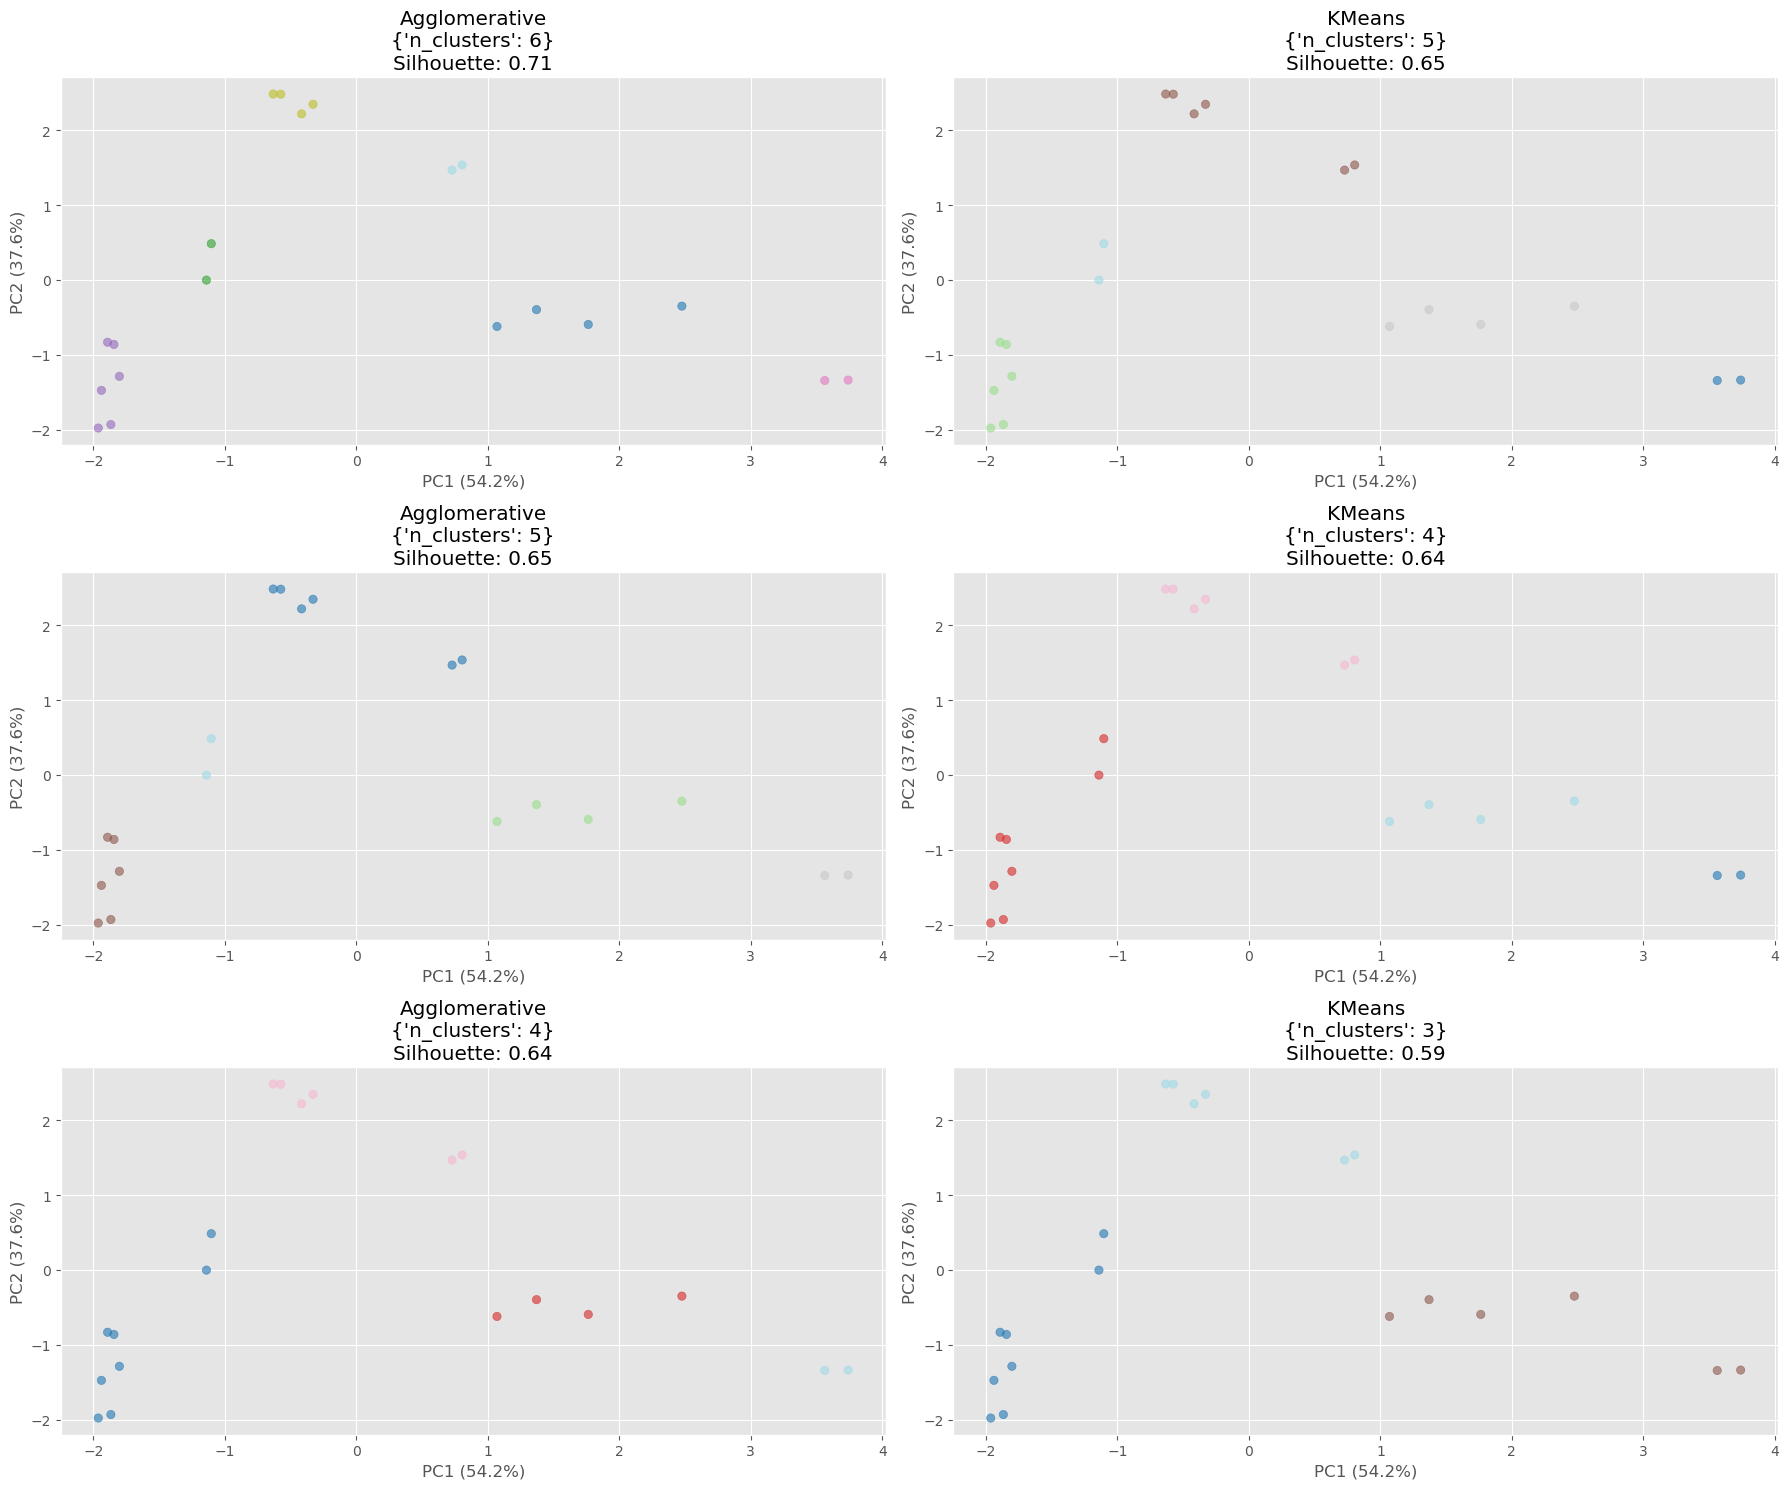


7. Analizando el mejor modelo en detalle...

=== Análisis de Clusters ===
Número de clusters: 6

Estadísticas por cluster:


Volumen_mean                        Volumen_std                        \
                mean   median     std count        mean  median     std count   
Cluster                                                                         
0            3325.36  3366.50  496.54     4      694.62  726.37  190.65     4   
1             719.77   719.77  107.37     2      892.11  892.11  134.14     2   
2             315.14   298.04   62.97     6     1000.47  957.77  171.50     6   
3            4244.80  4244.80    7.71     2      589.96  589.96   34.71     2   
4             333.47   333.03  176.19     4      113.81  100.48   40.80     4   
5            1463.61  1463.61    1.02     2      198.83  198.83   16.89     2   

        Volumen_median           ... Volumen_max       Volumen_min           \
                  mean   median  ...         std count        mean   median   
Cluster                          ...                                          
0              3499.30  3560.67  ...      287.86     4      261.48   174.42   
1                13.35    13.35  ...      369.80     2        0.00     0.00   
2                 0.02     0.01  ...      798.04     6        0.00     0.00   
3              4298.21  4298.21  ...       70.50     2     1467.31  1467.31   
4               337.65   336.16  ...      177.29     4       23.62    21.28   
5              1483.45  1483.45  ...      101.28     2      419.38   419.38   

                      Volumen_cv                     
            std count       mean median   std count  
Cluster                                              
0        198.88     4       0.22   0.22  0.09     4  
1          0.00     2       1.24   1.24  0.00     2  
2          0.00     6       3.19   3.19  0.16     6  
3         91.62     2       0.14   0.14  0.01     2  
4         21.68     4       0.38   0.40  0.12     4  
5         42.26     2       0.14   0.14  0.01     2  

[6 rows x 24 columns]

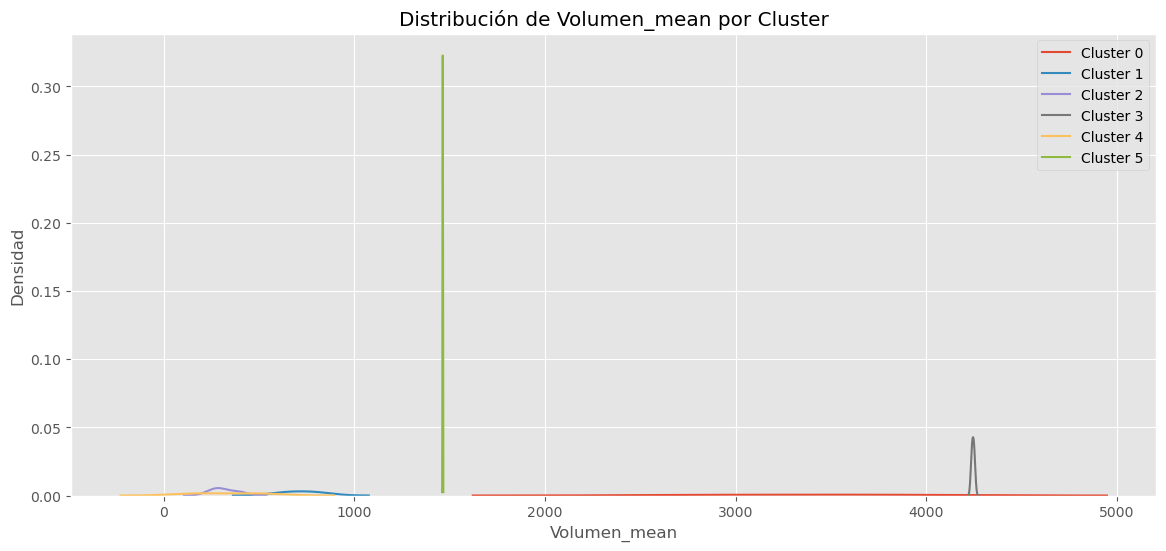

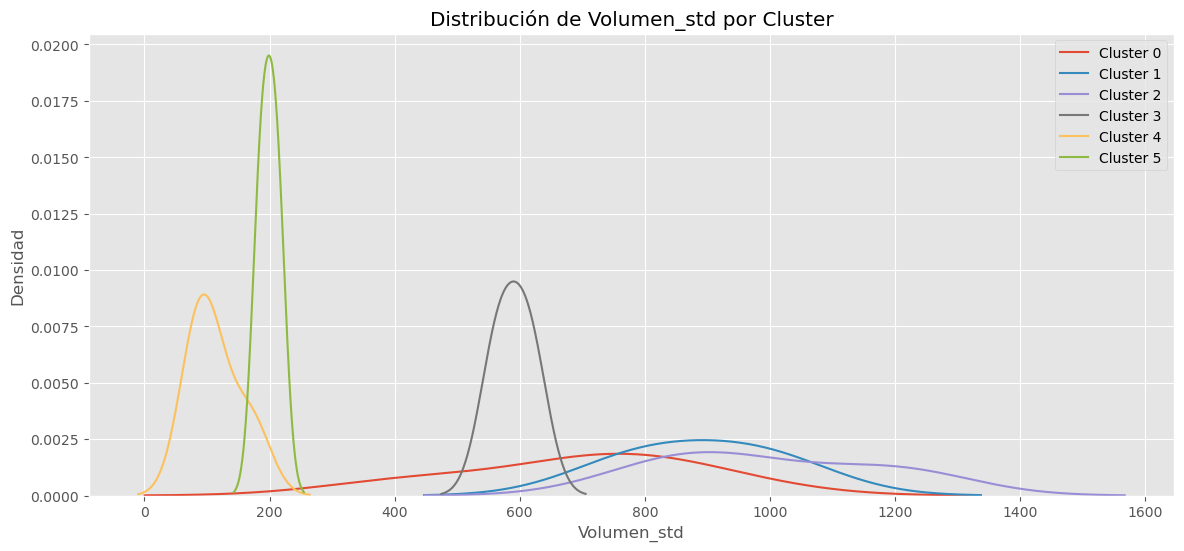

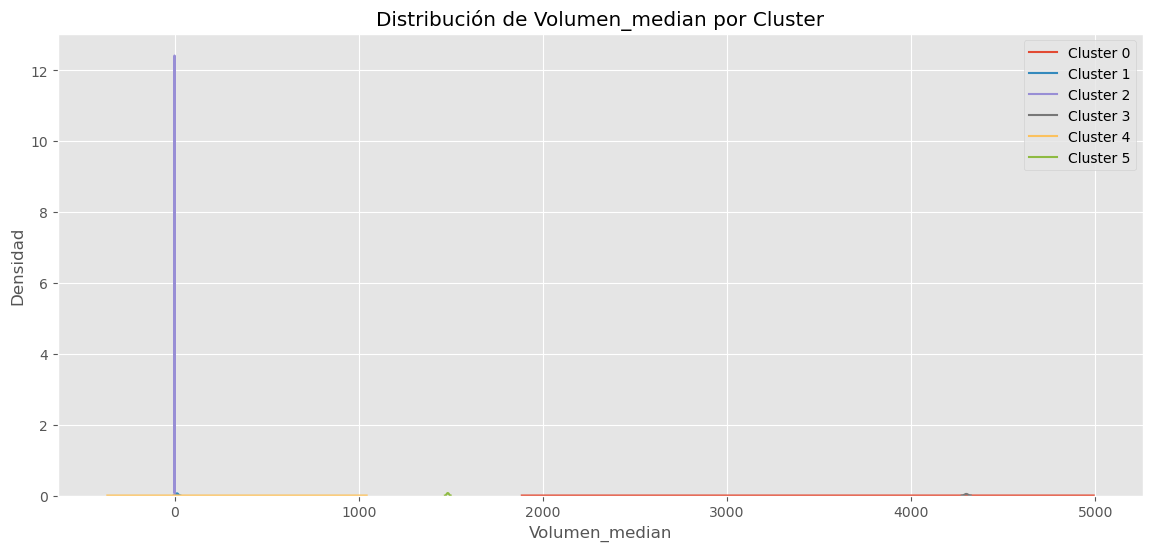

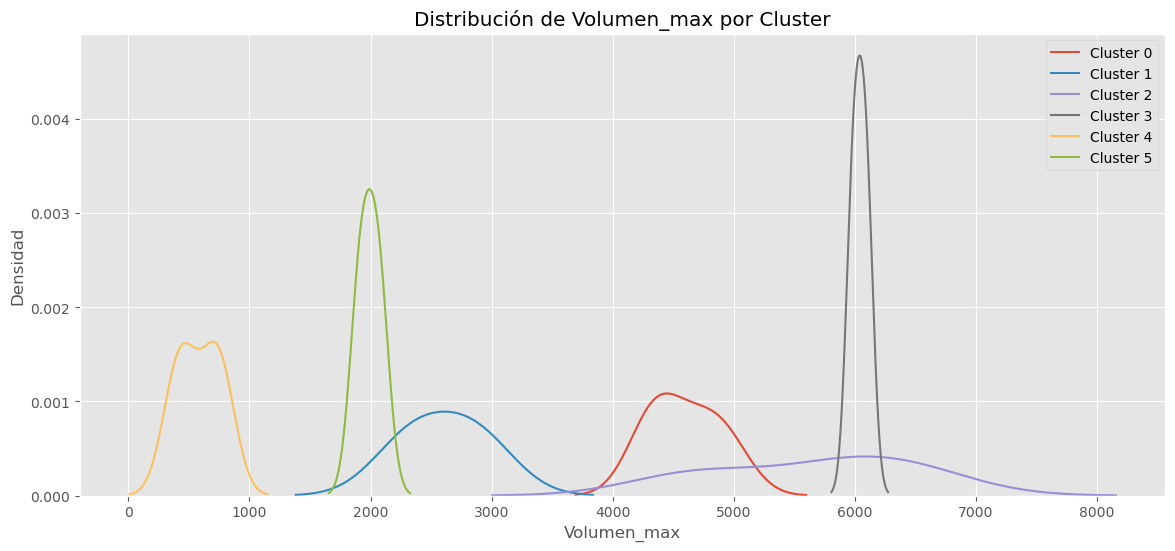

C:\Users\alfar\AppData\Local\Temp\ipykernel_9152\4174700591.py:379: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(analysis_df[analysis_df['Cluster'] == cluster][feature],
C:\Users\alfar\AppData\Local\Temp\ipykernel_9152\4174700591.py:379: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(analysis_df[analysis_df['Cluster'] == cluster][feature],


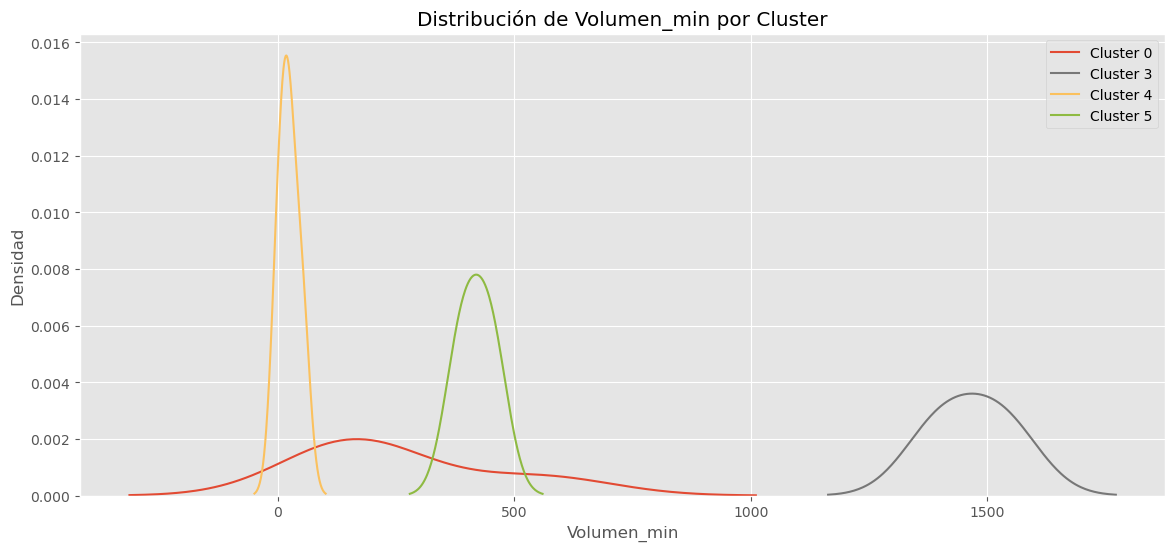

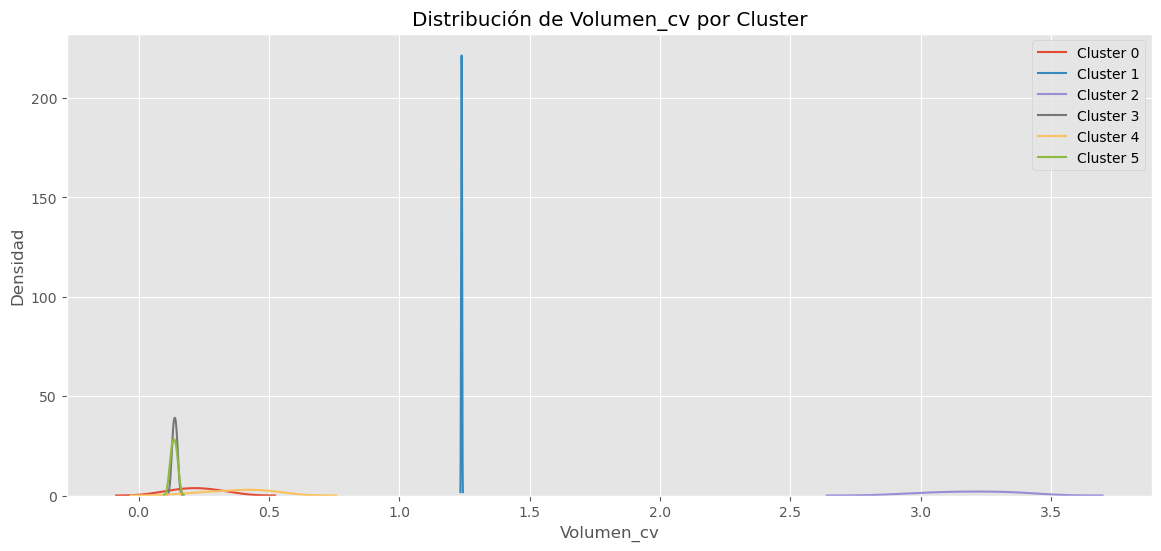

In [2]:
file_path = "Datos.xlsx"

# Ejecutar análisis completo enfocado en volumen
results = run_clustering_analysis(file_path, focus_on_volume=True)

In [3]:
# Para acceder a los resultados:
# best_model = results['best_model']
# best_labels = results['best_labels']
# client_features = results['client_features']

# results['cluster_stats']
results['clustering_results'].sort_values(by='calinski', ascending=False)

,model,params,n_clusters,silhouette,calinski,noise_ratio
3,DBSCAN,"{'eps': 1.0389602716546091, 'min_samples': 3}",3,0.832016,118.749961,0.35
5,DBSCAN,"{'eps': 1.5584404074819136, 'min_samples': 5}",2,0.780507,87.553468,0.40
12,Agglomerative,{'n_clusters': 6},6,0.712510,73.907207,0.00
4,DBSCAN,"{'eps': 1.5584404074819136, 'min_samples': 3}",3,0.730606,65.059833,0.20
2,KMeans,{'n_clusters': 5},5,0.650877,55.585791,0.00
11,Agglomerative,{'n_clusters': 5},5,0.650877,55.585791,0.00
7,DBSCAN,"{'eps': 2.077920543309218, 'min_samples': 7}",2,0.615261,39.553102,0.30
10,Agglomerative,{'n_clusters': 4},4,0.644541,39.524393,0.00
1,KMeans,{'n_clusters': 4},4,0.644541,39.524393,0.00
0,KMeans,{'n_clusters': 3},3,0.588133,30.905075,0.00


In [4]:
import pandas as pd

# Suponiendo que `results['client_features']` tiene un índice con los nombres de los clientes
clientes = results['client_features'].index.to_series().reset_index(drop=True)
grupos = pd.Series(results['best_labels'], name='grupo')

# Crear DataFrame con cliente y grupo
df_clusters = pd.DataFrame({'cliente': clientes, 'grupo': grupos})

# Guardar como Excel
df_clusters.to_excel('clientes_clustering_agglomerative.xlsx', index=False)


## Análisis de Modelos de Clustering

Se evaluaron tres algoritmos de agrupamiento: **KMeans**, **DBSCAN** y **Agglomerative Clustering**, utilizando como métricas principales el **coeficiente de Silhouette**, el **índice de Calinski-Harabasz** y, en el caso de DBSCAN, el **ratio de ruido**. También se consideró el número de clusters generados como un factor clave para la interpretación de los resultados.

El **coeficiente de Silhouette** cuantifica la cohesión y separación de los clusters, con valores cercanos a 1 indicando una segmentación bien definida. Por su parte, el **índice de Calinski-Harabasz** evalúa la relación entre la dispersión intra e inter-cluster: valores más altos reflejan agrupamientos más compactos y diferenciados. En cuanto al **noise ratio**, específico de DBSCAN, este indica el porcentaje de puntos que no fueron asignados a ningún cluster y que se consideran ruido.

---

### **Resumen de Resultados:**

| Modelo            | Parámetros               | Clusters | Silhouette | Calinski-Harabasz | Noise Ratio |
| ----------------- | ------------------------ | -------- | ---------- | ----------------- | ----------- |
| **DBSCAN**        | eps=1.04, min\_samples=3 | 3        | **0.832**  | **118.75**        | 35%         |
| **Agglomerative** | n\_clusters=6            | 6        | 0.713      | 73.91             | 0%          |
| **KMeans**        | n\_clusters=5            | 5        | 0.651      | 55.59             | 0%          |

---

### **Análisis Comparativo de Modelos:**

1. **DBSCAN** mostró el mejor desempeño en cuanto a separación de clusters, con el valor de Silhouette más alto (0.83) y el mayor índice de Calinski-Harabasz (118.75). No obstante, este modelo clasificó un 35% de los datos como ruido, lo cual puede ser una limitación significativa si se requiere una segmentación que incluya la totalidad de los puntos.

2. **Agglomerative Clustering** representó un compromiso equilibrado, generando seis clusters con un Silhouette elevado (0.71) y sin puntos de ruido. Esto lo posiciona como una opción sólida para escenarios donde la completitud del agrupamiento es prioritaria.

3. **KMeans**, con cinco clusters, obtuvo un Silhouette más bajo (0.65) y un índice de Calinski-Harabasz de 55.59. Aunque presenta un rendimiento moderado, sigue siendo útil en contextos donde se busca una solución rápida, eficiente y con clusters de forma esférica.

---

### **Distribución de Variables por Cluster:**

El análisis de las distribuciones de variables clave como `Volumen_mean`, `Volumen_std` y `Volumen_max` muestra claras diferencias entre los clusters, lo que respalda la validez de la segmentación:

* **Volumen\_mean**: Cluster 0 presenta un pico en torno a 2000, mientras que otros clusters alcanzan valores más altos (>4000).
* **Volumen\_std**: Los clusters 0–2 tienen baja dispersión (<500), mientras que los clusters 3–5 muestran una mayor variabilidad (>1000).
* **Volumen\_max**: El cluster 5 destaca por contener valores extremos (>7000), lo que podría reflejar clientes con consumos industriales.

---

### **Recomendaciones Estratégicas:**

1. **Modelo sugerido**:

   * Si se prioriza la **calidad de la segmentación**, **DBSCAN** es el más efectivo, siempre que se gestione adecuadamente el ruido.
   * Para mantener la **integridad del conjunto de datos**, **Agglomerative** con 6 clusters es la mejor alternativa.
   * **KMeans** es adecuado cuando se requieren resultados simples y eficientes, aunque con menor precisión.

2. **Acciones adicionales**:

   * Evaluar los puntos clasificados como ruido por DBSCAN para identificar posibles patrones anómalos o extremos.
   * Validar la segmentación de Agglomerative a través de variables de negocio como tarifas, hábitos de consumo o rentabilidad.
   * Explorar variantes de DBSCAN (por ejemplo, `eps=1.55`, `min_samples=5`) para balancear la separación de clusters con una menor proporción de ruido (aunque con Silhouette reducido a 0.78 y noise incrementado a 40%).

3. **Visualizaciones clave recomendadas**:

   * Gráficos de densidad por variable y cluster para detectar solapamientos.
   * Mapas de calor de correlación intra-cluster para identificar patrones internos.

---

### **Conclusión General:**

El modelo **Agglomerative con 6 clusters** se posiciona como la opción más equilibrada entre calidad de agrupamiento y cobertura del conjunto de datos, siendo especialmente útil para segmentaciones detalladas con propósito analítico o comercial. **DBSCAN**, aunque superior en métricas de cohesión y separación, requiere una gestión cuidadosa del ruido. Por último, **KMeans** puede considerarse en escenarios donde se valoren la simplicidad y la rapidez por encima del detalle.